## PyTorch computer vision libraries

| Module | Description |
| --- | --- |
| `torchvision` | Contains datasets, model architectures, and image transformations |
| `torchvision.datasets` | Contains popular datasets for computer vision including classificaiton, object detection, and more. It also contains some base classes for making custom datasets |
| `torchvision.models` | Contains popular model architectures known to perform well for computer vision that you can re-use for your own projects |
| `torchvision.transforms` | Images commonly need to be transformed (pre-processed, augmented) before being used with a model. This module contains common image transformations that you can use to augment your data |
| `torchvision.utils.data.Dataset` | This is the base dataset class for PyTorch |
| `torchvision.utils.DataLoader` | Creates a python iterable over a dataset (created with above) |

`Note:` the DataSet and DataLoader classes are not specific for computer vision, but are used for all types of data.

## Getting a dataset

We are going to be using Fashion MNIST, which contains small grayscale images of 10 different types of clothing. FashionMNIST can be loaded with `torchvision.datasets.FashionMNIST()`. To download it we need the following:;
- `root: str` : the directory to download the data to
- `train: bool` : whether to download the training set or the test set
- `download: bool` : whether to download the data or not
- `transform: torchvision.transforms` : which transformations would you like to do on the data?
- `target_transform: torchvision.transforms` : which transformations would you like to do on the labels?

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import Torchvision
import torchvision
from torchvision import datasets, transforms

# Other dependencies
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'PyTorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')

PyTorch version: 1.12.1, Torchvision version: 0.13.0a0


In [2]:
# download the training data:
train_data = datasets.FashionMNIST( root='FashionMNIST',
                                    train=True,
                                    download=True,
                                    transform = transforms.ToTensor(),
                                    target_transform=None)

# download the test data:
test_data = datasets.FashionMNIST( root='FashionMNIST',
                                    train=False,
                                    download=True,
                                    transform = transforms.ToTensor(),
                                    target_transform=None)

class_names = train_data.classes

### What are we working with here?

train_data and test_data are objects of type `torchvision.datasets.mnist.FashionMnisT`. They are iterable objects with a length of 60K and 10K respectively. Each element is a tuple of the form `(image, label)`. The image is a PIL image of size 28x28 and the label is a number between 0 and 9.

The shape of the image tensor is (1, 28, 28) and the label is a scalar. This corresponds to `CHW` format, where `C` is the number of channels, `H` is the height, and `W` is the width. The number of channels is 1 because the images are grayscale. The height and width are 28x28 because the images are 28x28 pixels.

You will also see `NCHW` and `NHWC` formats. `N` is the number of images in the batch (e.g, 32). PyTorch generally accepts `NCHW`, but explains that `NHWC` is has better performance and *should* be best practice

In [3]:
print(f'Length of training data: {len(train_data)}, Length of test data: {len(test_data)}')
print('Examining the first element of the training data:')
print(f'The object is of type: {type(train_data[0])}')
print(f'The first element of the object is of type: {type(train_data[0][0])} with shape {train_data[0][0].shape}')
print(f'The second element of the object is of type: {type(train_data[0][1])} with the value {train_data[0][1]}')

Length of training data: 60000, Length of test data: 10000
Examining the first element of the training data:
The object is of type: <class 'tuple'>
The first element of the object is of type: <class 'torch.Tensor'> with shape torch.Size([1, 28, 28])
The second element of the object is of type: <class 'int'> with the value 9


- We can access the training images with `train_data.data`, which is a giant tensor with 60,000 images of size 28x28
- We can access the training labels with `train_data.targets`, which is a vector with 60,000 labels in it
- We can convert the scalar targets to label-identities by accessing the `.classes` attribute of the dataset

In [4]:
# the training data is a giant tensor with 60,000 images of size 28x28, the train
print(f'Shape of training data : {train_data.data.shape} | Shape of training data labels: {train_data.targets.shape}')
print(f'The class names are:\n {train_data.classes}')

Shape of training data : torch.Size([60000, 28, 28]) | Shape of training data labels: torch.Size([60000])
The class names are:
 ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


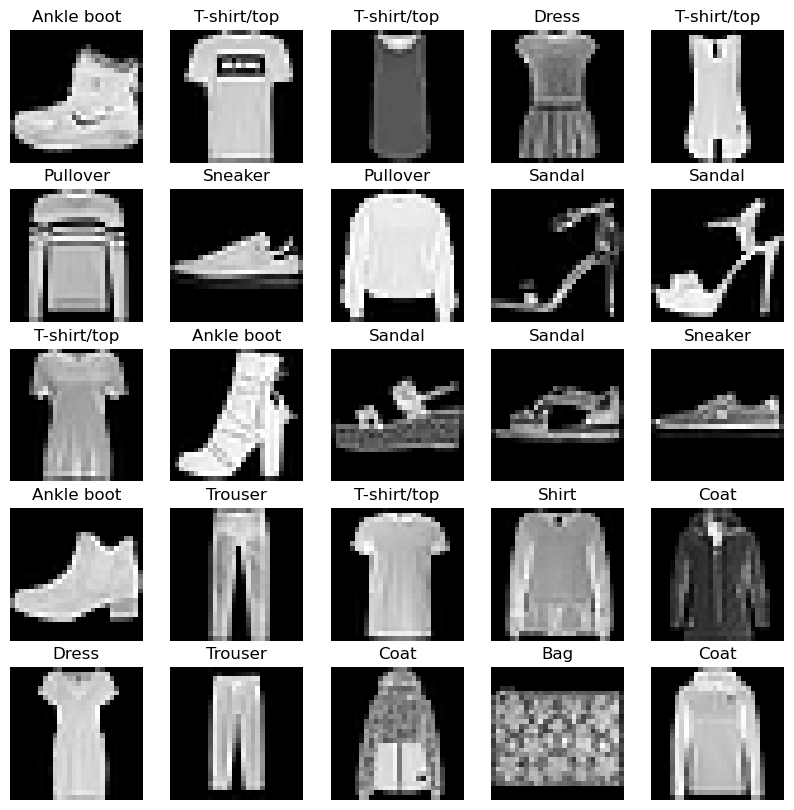

In [5]:
# Let's visualize some of the data:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    im, label = train_data[i]
    im = im.squeeze()
    ax.imshow(im, cmap='gray')
    ax.set_title(train_data.classes[label])
    ax.axis('off')
plt.show()


## Prepare a DataLoader

A DataLoader helps load data into a model for either training or inference. It turns a large Dataset like `torchvision.datasets.mnist.FashionMnisT` into a python iterable of smaller chunks, called `batches` or `minibatches`. 

- minibatches are more computationally efficient than going through the whole dataset at once
- gradient descent is performed once per minibatch, instead of once per epoch, which provides more opportunities for learning.
- batch size is a hyperparameter that you can tune to get better performance. 32 is usually a good starting spot, other common values are usually powers of two (e.g., 64, 128, 256, 512, 1024, etc.)

**Let's create DataLoaders for our training and test data:**

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dl = DataLoader(  train_data,             # dataset to turn into an iterable
                        batch_size=BATCH_SIZE,  # number of samples per batch
                        shuffle=False)          # shuffle train data every epoch, prevents model from learning order

test_dl = DataLoader(   test_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True)           # we don't need to shuffle the test data, this will make it easier to evaluate different models

# Visualize, visualize, visualize!
print(f'Length of train dataloader: {len(train_dl)} batches of size {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dl)} batches of size {BATCH_SIZE}')

Length of train dataloader: 1875 batches of size 32
Length of test dataloader: 313 batches of size 32


If we iterate through a dataloaders object, we find that it is a list of length 2
the first element of the list is a tensor of shape torch.Size([32, 1, 28, 28])
the second element of the list is a tensor of shape torch.Size([32])

let's visualize the first item in the batch:


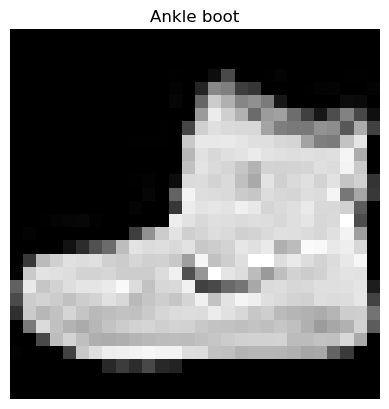

In [7]:
dataloaders_object = next(iter(train_dl))
print(f'If we iterate through a dataloaders object, we find that it is a list of length {len(dataloaders_object)}')
train_features_batch, train_labels_batch = dataloaders_object
print(f'the first element of the list is a tensor of shape {train_features_batch.shape}')
print(f'the second element of the list is a tensor of shape {train_labels_batch.shape}')

print("\nlet's visualize the first item in the batch:")
im, label = train_features_batch[0], train_labels_batch[0]
plt.imshow(im.squeeze(), cmap = 'gray')
plt.title(train_data.classes[label])
plt.axis('off')
plt.show()

## Can we use classic machine learning to classify the FashionMNIST dataset?

In [8]:
from pycaret.classification import *
import pandas as pd

train_data = datasets.FashionMNIST( root='FashionMNIST',
                                    train=True,
                                    download=True,
                                    transform = transforms.ToTensor(),
                                    target_transform=None)

# create a dataframe from the training data
train_features = train_data.data.numpy()
train_labels = train_data.targets.numpy()
train_features = train_features.reshape(60000, 28*28)
train_df = pd.DataFrame(train_features)
train_df['labels'] = train_labels
train_df_min = train_df.sample(frac=0.1, random_state=42)
print(train_df.shape)
print(train_df_min.shape)

(60000, 785)
(6000, 785)


In [9]:
#mnist_exp = setup(data = train_df_min, target = 'labels',  fold_shuffle=True, session_id=2)

Yes! It looks like we can exceed 80% accuracy using 'classic' techniques like GBMs and RFs

In [10]:
#best_model = compare_models()

## Build a linear baseline model:

We will build a simple baseline model with two linear layers. Because our input data are images, our first layer is going to be a `nn.Flatten()` layer. This will convert our height, width information into one long `feature vector`

Now that we have our `feature vector`, we can design the rest of the network architecture:
- `input_shape = 784` (height*width)
- `hidden_units = 10` (try playing with this)
- `output_shape = len(class_names)` we will need a single output neuron for each of the class labels we want to predict.

In [11]:
flatten_model = nn.Flatten()            # all nn modules can function as "modules" i.e., they can do a forward pass
input = train_features_batch[0]         # example input
output = flatten_model(input)           # example out put
print(f'input shape: {input.shape})')   
print(f'output shape: {output.shape}')  # (channels, height, width) -> (channels, height*width)


input shape: torch.Size([1, 28, 28]))
output shape: torch.Size([1, 784])


In [42]:
class FashionMNIST_V0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(  in_features = input_shape,
                        out_features = hidden_units),
            nn.Linear(  in_features = hidden_units,
                        out_features = output_shape)
            )
    
    def forward(self, x): return self.layers(x)

model_v0 = FashionMNIST_V0(input_shape=784, hidden_units=10, output_shape=len(class_names))
model_v0.to(device)
model_v0

FashionMNIST_V0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Set up loss, optimizer, and evaluation metrics

We're going to use Mr Bourke's helper scripts and accuracy functions defined here: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

In [43]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('File already downloaded')
else:
    print('Downloading file...')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

File already downloaded


In [44]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1)

## Creating a training loop for `batches` of data

Okay we have data, a model, an accuracy function, a loss function, and an optimizer. So how do we set up a training loop for `batches` of data? Easy, each item in the dataloader iterable is a tuple of (Features, Targets), so we can loop through the dataloader with `for X, y in train_dl` or `for batch (X, y) in train_dl`.

#### Calculating loss and accuracy

Remember, part of the reason we use batches is that not all our data can fit on a device (in particular, a GPU) at once. So we have to calculate loss and accuracy on `batches`, sum up the total loss, and the normalize to the number of batces that we calculated on. 

#### Results

The linear model did quite well, and fit the data with comparable accuracy to a random forest after just one epoch.

In [45]:
epochs = 1
for epoch in range(epochs):
    print(f'Epoch: {epoch} \n---------')
    train_loss = 0

    for batch_num, (X, y) in tqdm(enumerate(train_dl)):
        model_v0.train()
        y_pred = model_v0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # divide total training loss by the length of the train data loader...
    # ... so we get average loss per batch for each epoch
    train_loss /= len(train_dl)


    test_loss, test_acc = 0, 0
    model_v0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dl:
            test_pred = model_v0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            ''' 
            y_test is a vector of shape [32]
            y_pred is a matrix of shape [32, 10]
            Remember, the raw output of our model is a vector with a logit value for each of our target classes (10).
            When we pass this to the loss function, it needs to know the value of each logit to calculate confidence etc.
            However, when we pass this to the acc function, it just needs to know if there is an agreement between the
            most likely class prediction and the ground truth prediction. Accordingly, we need to reduce the matrix to a 
            vector by passing test_pred.argmax(dim=1)
            '''
            test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))
        
        # also normalize to get average per test batch 
        test_loss /= len(test_dl)
        test_acc /= len(test_dl)

    print(f'Train loss: {train_loss} | Test loss: {test_loss} | Test accuracy: {test_acc}% \n')

Epoch: 0 
---------


1875it [00:05, 346.99it/s]


Train loss: 0.5947472453117371 | Test loss: 0.561617910861969 | Test accuracy: 80.1417731629393% 



It's gong to be a huge pain to manually write out training and testing loops every time you train a model, so let's turn these into functions. We should also write a function to evaluate the peformance of our model, this way we can train a bunch of models and evaluate their performance relative to each other.

In [125]:
def train_step( model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn = accuracy_fn,
                device: torch.device = device):
    ''' 
    Step a PyTorch model through a training epoch of the data_loader.

    Args:
        model (torch.nn.Module): PyTorch model to train
        data_loader (torch.utils.data.DataLoader): PyTorch data loader to train on
        loss_fn (torch.nn.Module): PyTorch loss function to use
        optimizer (torch.optim.Optimizer): PyTorch optimizer to use
        accuracy_fn (function): Function to calculate accuracy
        device (torch.device): PyTorch device to use

    Returns:
        None
    '''

    train_loss, train_acc = 0, 0
    for X_train, y_train in data_loader:
        model.train()
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        train_loss += loss
        acc = accuracy_fn(y_true = y_train, y_pred = y_pred.argmax(dim=1))
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}')

def test_step(  model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn = torch.nn.Module,
            accuracy_fn = accuracy_fn,
            device: torch.device = device):
    ''' 
    Calculate model loss and accuracy on a test dataset.

    Args:
        model (torch.nn.Module): PyTorch model to test
        data_loader (torch.utils.data.DataLoader): PyTorch data loader to test on
        loss_fn (torch.nn.Module): PyTorch loss function to use
        accuracy_fn (function): Function to calculate accuracy
        device (torch.device): PyTorch device to use
    
    Returns:
        None
    '''

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch_num, (X_test, y_test) in enumerate(data_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            loss = loss_fn(y_pred, y_test)
            test_loss += loss
            acc = accuracy_fn(y_true = y_test, y_pred = y_pred.argmax(dim=1))
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f'Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}') 

def train_test( model: torch.nn.Module,
                train_data_loader: torch.utils.data.DataLoader,
                test_data_loader: torch.utils.data.DataLoader,
                accuracy_fn = accuracy_fn,
                device: torch.device = device,
                learn_rate: float = 0.1,
                opt_type: str = 'sgd',
                epochs = 1):
    ''' 
    Step through the training and test datasets for a defined number of epochs.

    Args:
        model (torch.nn.Module): PyTorch model to train
        train_data_loader (torch.utils.data.DataLoader): PyTorch data loader to train on
        test_data_loader (torch.utils.data.DataLoader): PyTorch data loader to test on
        accuracy_fn (function): Function to calculate accuracy
        device (torch.device): PyTorch device to use
        learn_rate (float): Learning rate to use
        opt_type (str): Optimizer type to use
        epochs (int): Number of epochs to train for
    
    Returns:
        None
    '''

    loss_fn = nn.CrossEntropyLoss()
    if opt_type == 'sgd':
        optimizer = torch.optim.SGD(params=model.parameters(), lr=learn_rate)
    elif opt_type == 'adam':
        optimizer = torch.optim.adam(params=model.parameters(), lr=learn_rate)
    else:
        import sys
        sys.exit('Optimizer type must one "sgd" or "adam"')
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}:\n--------')
        train_step(model = model,
                    data_loader=train_dl,
                    loss_fn=loss_fn,
                    optimizer=optimizer)

        test_step(model=model,
                    data_loader=test_dl,
                    loss_fn=loss_fn,
                    accuracy_fn=accuracy_fn)
    
def eval_model( model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
                accuracy_fn = accuracy_fn):
    ''' 
    Prints information about model performance on test dataset

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): PyTorch loss function to use
        accuracy_fn (function): Function to calculate accuracy
    
    Returns:
        None
    '''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch_num, (X_test, y_test) in enumerate(data_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            loss = loss_fn(y_pred, y_test)
            test_loss += loss
            acc = accuracy_fn(y_true = y_test, y_pred = y_pred.argmax(dim=1))
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    d = {'model_name' : model.__class__.__name__,
         'test_loss' : test_loss,
         'test_acc' : test_acc}
    for k, v in d.items():
        print(f'{k}: {v}')

torch.manual_seed(42)
model_v0 = FashionMNIST_V0(input_shape=784, hidden_units=10, output_shape=len(class_names))
train_test(model=model_v0,
            train_data_loader=train_dl,
            test_data_loader=test_dl,
            epochs = 3)

eval_model(model=model_v0,
        data_loader=test_dl,
        loss_fn=nn.CrossEntropyLoss(),
        accuracy_fn=accuracy_fn)

Epoch 0:
--------
Train loss: 0.58864 | Train accuracy: 79.10000
Test loss: 0.55527 | Test accuracy: 80.22165
Epoch 1:
--------
Train loss: 0.47433 | Train accuracy: 83.33167
Test loss: 0.51917 | Test accuracy: 81.97883
Epoch 2:
--------
Train loss: 0.45305 | Train accuracy: 84.16667
Test loss: 0.50333 | Test accuracy: 82.45807
model_name: FashionMNIST_V0
test_loss: 0.5035224556922913
test_acc: 82.44808306709265


## Nonlinearity

Could we get a better fit of the data using a non-linear model?

In [94]:
class FashionMNIST_V1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),  
            nn.ReLU()
        )
    def forward(self, x): return self.layers(x)

model_v1 = FashionMNIST_V1(input_shape=784, hidden_units=100, output_shape=len(class_names))
train_test(model=model_v1,
            train_data_loader=train_dl,
            test_data_loader=test_dl,
            epochs=10)


Epoch 0:
--------
Train loss: 0.64583 | Train accuracy: 76.84667
Test loss: 0.50094 | Test accuracy: 82.14856
Epoch 1:
--------
Train loss: 0.40937 | Train accuracy: 85.02167
Test loss: 0.43968 | Test accuracy: 84.15535
Epoch 2:
--------
Train loss: 0.36559 | Train accuracy: 86.51333
Test loss: 0.40013 | Test accuracy: 85.48323
Epoch 3:
--------
Train loss: 0.33829 | Train accuracy: 87.52333
Test loss: 0.38037 | Test accuracy: 85.97244
Epoch 4:
--------
Train loss: 0.31860 | Train accuracy: 88.19333
Test loss: 0.36750 | Test accuracy: 86.72125
Epoch 5:
--------
Train loss: 0.30237 | Train accuracy: 88.78833
Test loss: 0.35794 | Test accuracy: 86.95088
Epoch 6:
--------
Train loss: 0.28950 | Train accuracy: 89.21000
Test loss: 0.35970 | Test accuracy: 86.63139
Epoch 7:
--------
Train loss: 0.27684 | Train accuracy: 89.64333
Test loss: 0.35540 | Test accuracy: 86.87101
Epoch 8:
--------
Train loss: 0.26688 | Train accuracy: 89.95833
Test loss: 0.36441 | Test accuracy: 86.95088
Epoch 9:
-

## Convolutional neural network

Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

Where the contents of [Convolutional layer -> activation layer -> pooling layer] can be upscaled and repeated multiple times, depending on requirements.

### Input layer

This is the input image. In our case, it's a single-channel image of size 28x28. We can represent this as a tensor of shape (1, 28, 28). In general, the shape of the input tensor is (channels, height, width). The number of channels is commonly 3 for RGB images, but in principle it can be more or less depending on the source of the image.

### Convolutional layers

The first convolutional layer connects the input layer (image) to the first layer of hidden units. If the input layer has three channel, and the first hidden layer has ten channels, that means that each original image channel is connected to each of the ten hidden units. Each hidden unit has a unique kernel for each of the three channels, so there are 30 kernels in total. The kernels themselves make up the weights of each hidden unit. If a give hidden unit has a kernel of size 3x3, then the hidden unit has 9 weights. The total number of weights in the first hidden layer is 30x9 = 270.

#### Kernel size

The size of the kernel dictates what kind of information the layers extract. A 3x3 kernel will mostly extract local information while a 30x30 kernel will largely extract global information. The specific size of the kernel is a hyperparameter that you can tune to get better performance.

#### Stride

Stride indicates how many pixels the kernel should shift over at a time. Similar to kernel size, a smaller stride will capture more local information while a larger stride will capture more global information. A larger stride value will produce smaller intermediate layers which can be useful to accelerate computation. The specific stride value is a hyperparameter that you can tune to get better performance. `Important:` the stride value, kernel size, padding, and image image size must be chosen so that the output layer has an integer size. 

#### Padding

Padding compensates for the kernel failing to extend beyond the edge of the image. If the kernel `only` samples image pixels then the resulting convolution will be smaller than the original image. The reduction in size will depend on the kernel size and stride. If desired, the edges of the image can be padded (commonly with zeros, although other approaches exist) so that the convolutional layer has the same size as the original image. Padding is a hyperparameter that you can tune to get better performance.

### Activation function

The activation function is applied to the output of the convolutional layer. It's purpose is to introduce non-linearity into the model. The most common activation function is the rectified linear unit (ReLU). The sigmoid and tanh functions are also commonly used, but they are not as computationally efficient as ReLU. The specific activation function is a hyperparameter that you can tune to get better performance.

### Pooling layers

Pooling functions to reduce the size of intermediate layers and distill features into smaller feature maps. The most common pooling function is max pooling, which takes the maximum value of a kernel of pixels. Pooling layers also require a kernel size and stride value that can be tuned to get better performance. For example, TinyVGG uses max pooling with a kernel size of 2x2 pixels and a stride of two pixels. This effectively discards 75% of the information (only 1 of 4 pixels values are preserved) and halves the size of the subsequent layer.

### Flatten layer

The flatten layer functions to convert the distilled features maps from the rest of the network into a single feature vector that can be classified with a dense layer. The flatten layer is a PyTorch module that has no trainable parameters. If the final layer of a CNN has 10 channels (neurons) that are each 13x13 pixels, then the flatten layer will convert this into a single feature vector of length 10x13x13 = 1690. 

### Output layer

After the flatten layer, the network needs to distill the (e.g.,) 1690 features in the flatten layer into (e.g.,) 10 classes. This is accomplished with a linear layer. The output of the linear layer will have the same shape as the number of output classes. 

#### Logits

The raw output of our final linear layers are referred to as `logits`. These are unscaled values that can be interpreted as the probability of a given class. However, they are not probabilities because they have not been normalized to sum to 1.0. To get probabilities, we need to apply a softmax function to the logits.

#### Softmax

The softmax function is a mathematical function that takes a vector of k real values returns a vector of k real values to sum to 1.0. The softmax function is applied to the logits to get probabilities. The softmax function is a PyTorch module that has no trainable parameters.

if we have two classes, `cat` and `dog` with logs of 2 and 1 respectively, the softmax function will normalize:

- p(cat) = e^2 / (e^2 + e^1) = 0.731
- p(dog) = e^1 / (e^2 + e^1) = 0.269
- Note that 0.269 + 0.731 = 1.0

The utility of softmax over argmax is that it returns a vector of values between 0 and 1 which correspond to the confidence of the model in each class. This allows the output to be differentiable and used in a loss function. In contrast, the argmax function returns of vector of 0s and 1s, which is not differentiable. It is common to use softmax during training, and switch the argmax function during inference because it returns a single class value. 

In [145]:
class FashionMNIST_V2(nn.Module):
    def __init__(self,
                input_shape: int,                   
                hidden_units: int,                  
                output_shape: int):                 # number of classes to predict between
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,    # number of channels in input
                      out_channels = hidden_units,  # number of channels in hidden layer
                      kernel_size = 3,              
                      stride = 1,                   # with a kernel size of 3, a stride of 1, and padding of 1, 
                      padding = 1),                 # the output will be the same size as the input
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,           # with a kernel size of 2, and a stride of 2,
                         stride = 2)                # the output feature map will be half the size of the input
            )
        '''
        Because of the kernel size, stride, and padding, we have preserved the image size between the first two 
        convolutional layers, but the output of the max pooling layer is half the size of the input. So if we start
        with a [1,28,28] input and specify 10 hidden units, we will have a [10,14,14] output from from the first block.
        '''
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)
            )
        '''
        The second block has the same architecture as the first, but the input is the output of the first block, so
        the output of the second block will be [10,7,7].
        '''
        self.flat = nn.Flatten(start_dim = 1, end_dim = -1)     # the default start dim is 1, which converts [10,7,7] to [10,49] instead of [490]
                                                                # the first dim will be the minibatch, so we add an empty dimension to our test image
                                                                # before passing it through the model.
        self.classifier = nn.Linear(in_features = hidden_units * 7 * 7,
                                    out_features = output_shape)
        '''
        The final "block" is a dense layer converting the flattened feature map into the output shape (the number of classes).
        '''
    
    def forward(self, x): 
        #print(f'shape of x before block 1: {x.shape}')     # -> shape of x before block 1: torch.Size([1, 1, 28, 28])
        x = self.block_1(x)
        #print(f'shape of x after block 1: {x.shape}')      # -> shape of x after block 1: torch.Size([1, 10, 14, 14])
        x = self.block_2(x)
        #print(f'shape of x after block 2: {x.shape}')      # -> shape of x after block 2: torch.Size([1, 10, 7, 7])
        x = self.flat(x)
        #print(f'shape of x after flattening: {x.shape}')   # -> shape of x after flattening: torch.Size([1, 490])
        x = self.classifier(x)
        #print(f'shape of x after classifier: {x.shape}')   # -> shape of x after classifier: torch.Size([1, 10])
        return x

model_v2 = FashionMNIST_V2(input_shape=1, hidden_units=10, output_shape=10).to(device)
test_im = train_dl.dataset[0][0].unsqueeze(dim=0).to(device)
_ = model_v2(test_im)

### Training

Looks like everything is working as expected, let's define a loss function and optimizer and train the model.

Nice! We're approaching 90% accuracy after just three epochs, considerably better than the linear model. Our nonlinear model could get 87% accuracy after 10 epochs, but our CNNN is already beating that after just three epochs. After 10 epochs the CNN is barely beating that at ~90% accuracy.

Can we improve this model? We can try adding more convolutional layers before each pooling step, or by using more hidden layers. We can also experiment with things like [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) and [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) to improve performance.

In [148]:
model_v2 = FashionMNIST_V2(input_shape=1, hidden_units=10, output_shape=10).to(device)
_=train_test(model=model_v2,
            train_data_loader=train_dl,
            test_data_loader=test_dl,
            epochs=1)
'''
Epoch 9:
--------
Train loss: 0.24619 | Train accuracy: 91.02333
Test loss: 0.29825 | Test accuracy: 89.56669
'''

Epoch 0:
--------
Train loss: 0.45403 | Train accuracy: 83.69833
Test loss: 0.36184 | Test accuracy: 87.20048


'\nEpoch 9:\n--------\nTrain loss: 0.24619 | Train accuracy: 91.02333\nTest loss: 0.29825 | Test accuracy: 89.56669\n'

### On softmax

We don't need to include the softmax function during nn training because nn.CrossEntropyLoss has softmax built in. However, if we want to convert raw logits to probabilities during inference, we can use nn.Softmax or if we just want to know the class with the highest probability, we can use argmax.

Ankle boot


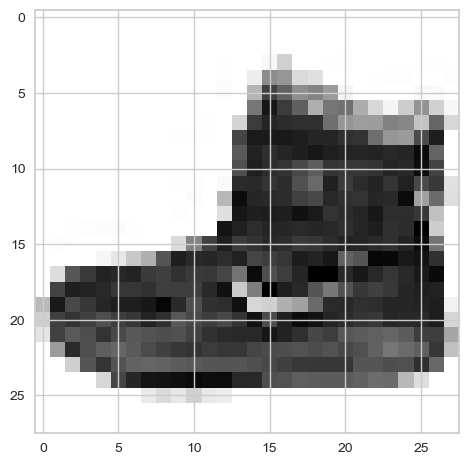

In [164]:

def predict_item(model: nn.Module,
                 item: torch.tensor):
    ''' 
    '''
    raw = model(item)
    pred_ind = raw.argmax()
    pred_class = class_names[pred_ind]
    print(pred_class)



plt.imshow(test_im.squeeze())

predict_item(model=model_v2, item=test_im)

